# Analysis : Bias in Digitized Newspapers



## Load Data and Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tools.helper_functions import *
from tools.mappings import *
from scipy.stats import entropy
from collections import defaultdict,Counter
import seaborn as sns
sns.set()

In [3]:
# set path for storing the images
figures_path = Path('figures')
figures_path.mkdir(exist_ok=True)

## Preprocess Data

In [4]:
path = Path('../data/Press_Directories_1846_1920_JISC_final.csv')
df = pd.read_csv(path,index_col=0)
print(df[~df['POLITICS'].isnull()].shape)
df = complete_records(df,'POLITICS')
print(df[~df['POLITICS'].isnull()].shape)

(36573, 19)
(38170, 20)


In [5]:
df['first_price'] = df['PRICE'].apply(lambda x: x.split('<SEP>')[0] if isinstance(x,str) else x)
df['first_price'] = df['first_price'].apply(lambda x: convert_price.get(x,None))
df = complete_records(df,'first_price')
df['first_price_red'] = df.first_price.apply(reduce_price,ceil=True)


In [6]:
#df[(df.CATEGORY.isin(['provincial','irish','scottish','welsh','irish'])) & (df.YEAR <= 1900)]['POLITICS'].value_counts()

# Political Bias in the JISC corpus

## Appendix Section C: Reclassification

In [7]:
temp = defaultdict(list)
for k,v in remap_politics.items():
    temp[v].append(k)
for k,v in  temp.items():
    v = ['"{}"'.format(','.join(i.split(";"))) for i in v]
    print(f'Mapped to {k.upper()}: ', '; '.join(v),)
    print()

Mapped to LIBERAL:  "liberal"; "liberal, moderate"; "whig"; "liberal, liberal"; "liberal, free-trade"; "ultra, liberal"; "liberal, independent"; "liberal, ultra"; "independent, liberal"; "liberal, non-comformist"; "advanced, liberal, non-comformist"; "moderate, liberal"; "utlra, liberal"; "republican"; "advanced, liberal"; "independent, li"; "independent, advanced, liberal"; "liberal, conservative, independent"; "liberal, tory, independent"; "tory, liberal"; "nationalist, liberal"; "national, liberal"

Mapped to CONSERVATIVE:  "conservative"; "tory"; "tory, old"; "high, tory"; "protestant, conservative"; "constitutional"; "anti-whig"; "independent, conservative"; "moderate, conservative"; "conservative, conservative"; "llberal, conservative"; "conservative, independent"; "unionist"; "liberal, unionist"; "independent, constitutional"; "conservative, unionist"; "conservative, constitutional"; "unionist, conservative"; "unionist, liberal"; "unionist, independent"

Mapped to NON-ALIGNED:  

In [8]:
df['POLITICS-2'] = df['POLITICS'].copy()
df.replace({'POLITICS-2':remap_politics},inplace=True)

In [9]:
df_prov = df[df['CATEGORY'].isin(['provincial','welsh','scottish','irish'])]
df_prov = df_prov[df_prov.YEAR <= 1900]
df_prov.shape

(27260, 24)

## Figure 5

In [10]:
len(df['POLITICS'].value_counts()),len(df['POLITICS-2'].value_counts())

(226, 150)

In [11]:
df_prov['POLITICS-2'].unique()

array(['liberal', 'conservative', 'non-aligned', 'radical', nan,
       'independent', 'irish nationalist', 'denominational', 'other',
       'labour'], dtype=object)

In [12]:
labels = set(i.strip() for l in df_prov['POLITICS'].unique() for i in str(l).split(';'))
len(labels)

45

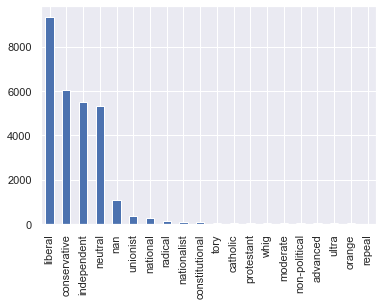

In [13]:
fig = pd.Series(dict(Counter(i.strip() for l in df_prov['POLITICS'] 
                       for i in str(l).split(';')).most_common()[:20])).plot(kind='bar').get_figure()
fig.savefig(figures_path / 'figure_5_l.png')

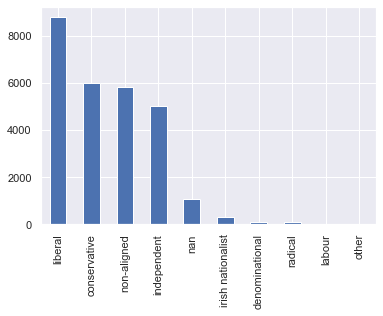

In [14]:
fig = pd.Series(dict(Counter(l for l in df_prov['POLITICS-2']).most_common()[:20])).plot(kind='bar').get_figure()
fig.savefig(figures_path / 'figure_5_r.png')

# Figure 6

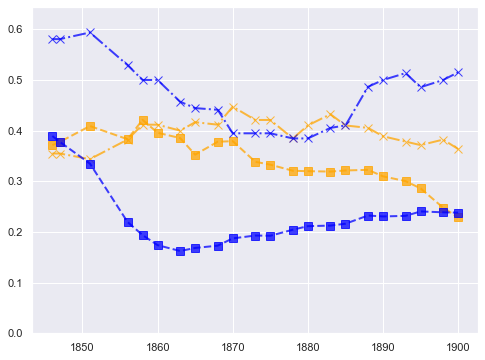

In [15]:
fig = plot_comparison_selected_categories([("liberal",'orange'),("conservative","blue")],
                                          df_prov, 'POLITICS-2', figures_path / 'figure_6_l.png')

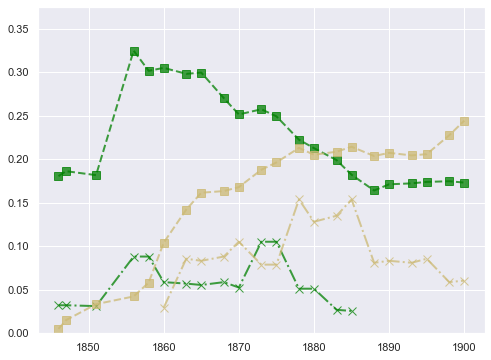

In [16]:
plot_comparison_selected_categories([("non-aligned",'green'),("independent","y")]
                                    ,df_prov,'POLITICS-2',figures_path / 'figure_6_r.png')

## Figure 7

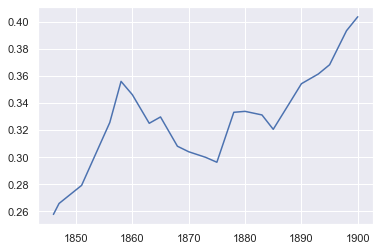

In [17]:
target = 'POLITICS'
parties = [p for p in df_prov[target].unique() if isinstance(p,str)]
_,_,d= divergence(df_prov,parties,target=target) # df_prov[target].unique()
fig = d.plot(legend=False).get_figure()
fig.savefig(figures_path / 'figure_7_l.png')

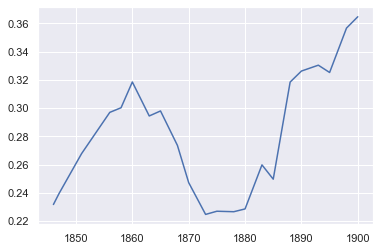

In [18]:
target = 'POLITICS-2'
parties = [p for p in df_prov[target].unique() if isinstance(p,str)]
_,_,d= divergence(df_prov,parties,target=target) # df_prov[target].unique()
fig = d.plot(legend=False).get_figure()
fig.savefig(figures_path / 'figure_7_r.png')

In [19]:
parties

['liberal',
 'conservative',
 'non-aligned',
 'radical',
 'independent',
 'irish nationalist',
 'denominational',
 'other',
 'labour']

## Figure 8

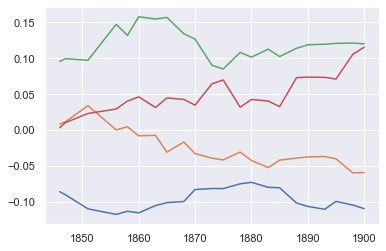

In [20]:
labels = ['conservative','liberal','non-aligned','independent']
prop_ppp,prop_sample, _ = divergence(df_prov, labels)

prop_ppp.columns = labels
prop_sample.columns = labels

kl_ps = []
for year in prop_ppp.index:
    kl_ps.append(list(map(kl_p,zip(prop_ppp.loc[year],prop_sample.loc[year]))))

kl_ps_df = pd.DataFrame(kl_ps, columns=labels)
kl_ps_df.index = df_prov.YEAR.unique()
fig = kl_ps_df.plot(legend=False).get_figure()
fig.savefig(figures_path / 'figure_8.png')

# Price and place as other dimensions of bias 

# Price

In [21]:
df_prov.loc[df_prov['first_price_red'] > 6.0,'first_price_red'] = 6
selected_prices = list(df_prov.first_price_red.value_counts().index)
selected_prices.sort()
selected_prices

[0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

## Figure 9

In [22]:
target = 'first_price_red'
props_pop,props_sample,d = divergence(df_prov,selected_prices,target=target)
props_pop.columns = selected_prices
props_sample.columns = selected_prices

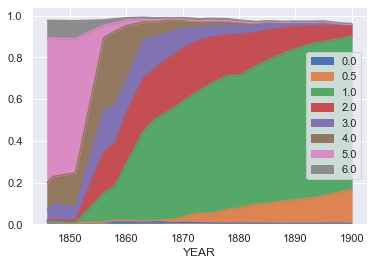

In [23]:
fig = props_pop.plot(kind='area').get_figure()
fig.savefig(figures_path / 'figure_9_l.png')

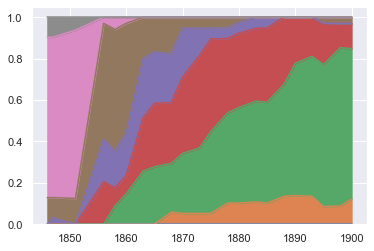

In [24]:
fig = props_sample.plot(kind='area',legend=False).get_figure()
fig.savefig(figures_path / 'figure_9_r.png')

## Figure 10

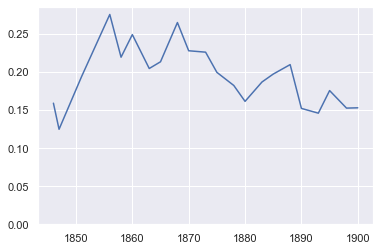

In [25]:

fig = d.plot(legend=False,ylim=(.0,max(d.values)[0]+.01)).get_figure()
fig.savefig(figures_path / 'figure_10_l.png')


In [26]:
labels = selected_prices

props_pop.columns = labels
props_sample.columns = labels

kl_ps = []
for year in props_pop.index:
    
    kl_ps.append(list(map(kl_p,zip(props_pop.loc[year],props_sample.loc[year]))))

kl_ps_df = pd.DataFrame(kl_ps, columns=labels)
kl_ps_df.index = df_prov.YEAR.unique()


In [27]:
kl_ps_df.std(axis=0).sort_values()

0.0    0.003031
6.0    0.005432
0.5    0.013040
5.0    0.022233
3.0    0.026328
4.0    0.037046
2.0    0.047575
1.0    0.055974
dtype: float64

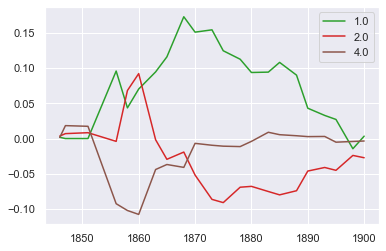

In [28]:
fig = kl_ps_df[[1.0,2.0,4.0]].plot(legend=True, color=['#2ca02c','#d62728','#8c564b']).get_figure()
fig.savefig(figures_path / 'figure_10_r.png')

## Appendix E 

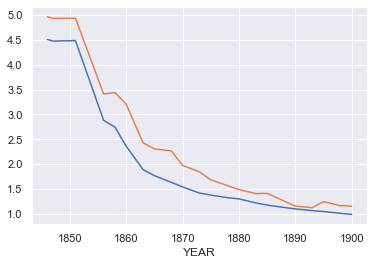

In [29]:
df_prov[(~df_prov['first_price'].isnull()) & (df_prov['first_price'] <= 12.0)].groupby('YEAR')['first_price'].mean().plot()
fig = df_prov[df_prov.IN_JISC > 0].groupby('YEAR')['first_price_red'].mean().plot().get_figure()
fig.savefig(figures_path/'appendix_e.png')

# Place

In [30]:
df_prov_gb = df_prov[df_prov.CATEGORY.isin(['provincial','welsh','scottish'])]
counties = df_prov_gb.COUNTY_PUB.value_counts()
selected_counties = list(counties[counties > 1].index)
len(counties),len(selected_counties)

(88, 88)

In [31]:
places_joined_df = pd.read_csv('../wikidata_counties.csv')

In [32]:
df_prov_gb_joined = df_prov_gb.merge(places_joined_df,left_on='COUNTY_PUB',right_on='name',how='left')

## Appendix E

<AxesSubplot:>

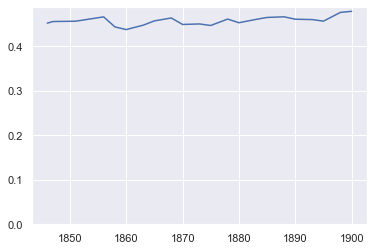

In [33]:
selected_counties = df_prov_gb_joined.wikidata_id.unique()
props_pop,props_sample,d= divergence(df_prov_gb_joined,selected_counties,target='wikidata_id')
d.plot(legend=False,ylim=(.0,max(d.values)[0]+.01))

## Figure 11

In [34]:
labels = selected_counties

props_pop.columns = labels
props_sample.columns = labels

def kl_p(x):
    if x[0]+x[1] > .0:
        return x[0] * np.log(2*x[0]/(x[0]+x[1]))
    else:
        return .0
        

kl_ps = []
for year in props_pop.index:
    kl_ps.append(list(map(kl_p,zip(props_pop.loc[year],props_sample.loc[year]))))


In [35]:
kl_ps_df = pd.DataFrame(kl_ps, columns=labels)
kl_ps_df.index = props_pop.index

In [36]:
kl_ps_df.drop('Q84',inplace=True, axis=1)

In [37]:
to_kepler = kl_ps_df.T
to_kepler['sum'] = to_kepler.sum(axis=1)
to_kepler['mean'] = to_kepler.mean(axis=1)
to_kepler = to_kepler.merge(places_joined_df,left_index=True,right_on='wikidata_id')

In [38]:
to_kepler['sum_std'] = (to_kepler['sum'] - to_kepler['sum'].mean()) / to_kepler['sum'].std() 
to_kepler['mean_std'] = (to_kepler['mean'] - to_kepler['mean'].mean()) / to_kepler['mean'].std() 

In [39]:
to_kepler['mean_std_int'] = to_kepler['mean_std'].astype(np.int64)
to_kepler.loc[to_kepler['mean_std_int'] >= 3,'mean_std_int'] = 3
to_kepler.loc[to_kepler['mean_std_int'] <= -3,'mean_std_int'] = -3

In [40]:
to_kepler['mean_std_int'].unique()

array([ 0, -1,  1, -3,  2,  3, -2])

In [41]:
selected_columns = ['mean','mean_std','mean_std_int','wikidata_id','english_label','latitude','longitude']
to_kepler[selected_columns].to_csv(figures_path / 'figure_11_kepler_data.csv')

In [42]:
print('All done!')

All done!


# Fin